<h2> Spam Email Classifier </h2>

<h4>Import libraries

In [1]:
# Import relevant libraries
import re
import nltk
import spacy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,mean_squared_error,classification_report

<h4> Setting parameters

In [18]:
# setting seaborn parameters
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(6,6)})

In [3]:
# setting matplotlib parameters for better visualization of graphs
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.color':'white',
         'ytick.color':'white'
         }

plt.rcParams.update(params)
%matplotlib inline

<h4> Import dataset

In [7]:
#importing dataset
df=pd.read_csv("spam_ham_dataset.csv")

In [8]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


<h4> Basic preprocessing : Removing unwanted colums, Checking for missing values, Removing duplicate rows

In [9]:
#drop unwanted column
df.drop(columns=['Unnamed: 0'],inplace=True)

In [10]:
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\nthis deal is to ...,0


In [11]:
# check for missing values
df.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [12]:
# check for duplicate values
df.duplicated().sum()

178

In [13]:
# remove duplicates
df = df.drop_duplicates(keep='first')
print(df.duplicated().sum())

0


<h4> Exploring more about data

In [14]:
# num of rows and columns in the data
df.shape

(4993, 3)

In [15]:
# count of spam and ham emails in the data
df['label'].value_counts()

ham     3531
spam    1462
Name: label, dtype: int64

In [16]:
#general summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      4993 non-null   object
 1   text       4993 non-null   object
 2   label_num  4993 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 156.0+ KB


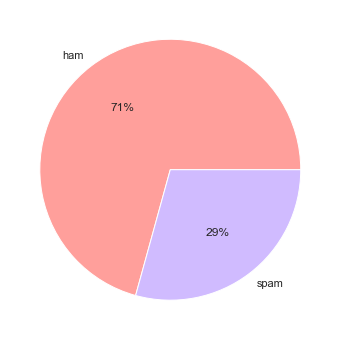

In [19]:
#create pie chart
plt.pie(df['label'].value_counts(), labels = ['ham','spam'], colors = sns.color_palette('pastel')[3:5], autopct='%.0f%%'          )
plt.show()

<h4> Creating some more features to observe pattern differences among spam and ham emails

In [20]:
# Num of characters per document
df['num_characters'] = df['text'].apply(len)

In [21]:
# Num of words per document
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [24]:
# Num of sentences per document
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [25]:
df.head()

,label,text,label_num,num_characters,num_words,num_sentences
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0,322,68,3
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0,95,24,1
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,2515,551,20
3,spam,"Subject: photoshop , windows , office . cheap ...",1,404,49,3
4,ham,Subject: re : indian springs\nthis deal is to ...,0,332,71,3


In [26]:
#detailed summary of dataset
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4993.000000,4993.000000,4993.000000
mean,1050.484478,233.678149,10.202884
std,1524.189679,340.702932,22.003030
min,10.000000,2.000000,1.000000
25%,251.000000,55.000000,3.000000
50%,545.000000,125.000000,6.000000
75%,1238.000000,288.000000,12.000000
max,31860.000000,8863.000000,1163.000000


In [27]:
# detailed summary of ham emails
df[df['label_num'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,3531.000000,3531.000000,3531.000000
mean,977.089776,230.516001,8.804871
std,1380.153944,337.018933,22.303918
min,17.000000,3.000000,1.000000
25%,236.000000,53.000000,3.000000
50%,528.000000,128.000000,5.000000
75%,1230.000000,298.500000,10.000000
max,31860.000000,8863.000000,1163.000000


In [28]:
# detailed summary of spam emails
df[df['label_num'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,1462.000000,1462.000000,1462.000000
mean,1227.746238,241.315321,13.579343
std,1814.119546,349.439381,20.883535
min,10.000000,2.000000,1.000000
25%,299.000000,60.000000,3.000000
50%,577.500000,119.500000,8.000000
75%,1272.750000,252.750000,15.000000
max,21749.000000,3963.000000,331.000000


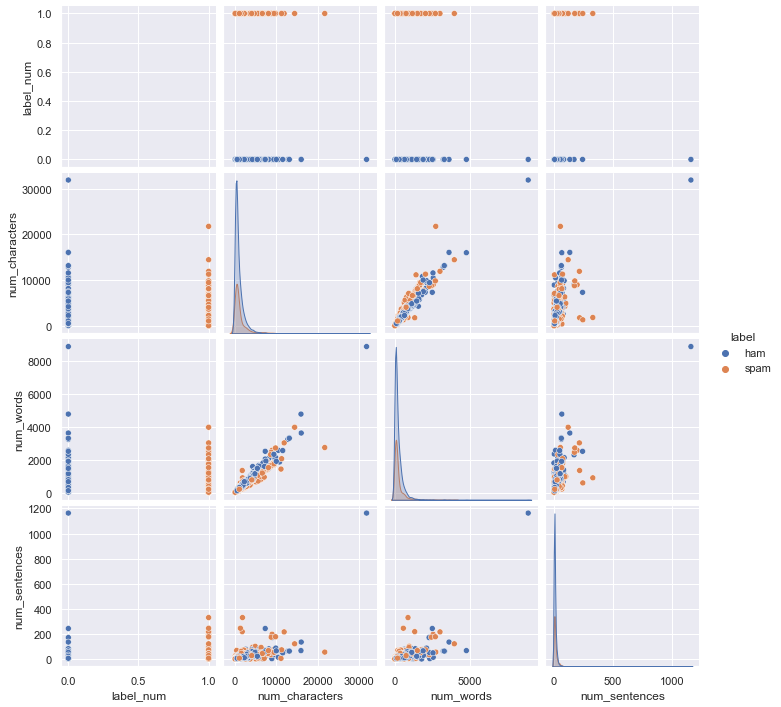

In [32]:
# plotting the graph 
sns.pairplot(df,hue='label')

<AxesSubplot:>

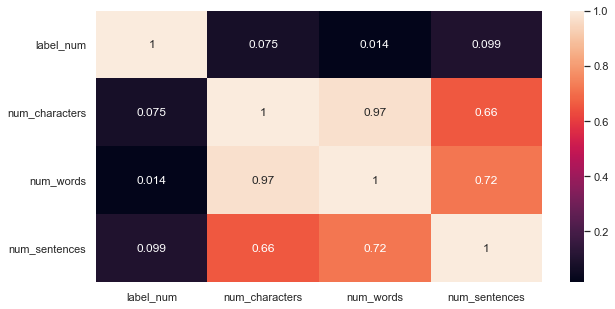

In [33]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(df.corr(),annot=True)

<h4>Text Preparation

In [34]:
# converting emails to lower case
df['text']=df['text'].str.lower()

In [35]:
# text cleaning : tokenization, removal of stop words, removal of digits, removal of punctutations and lemmatization
nlp=spacy.load("en_core_web_sm")
def extraction(list_item):
    temp_list=[]
    #remove digits
    rem_digit="".join([w for w in list_item if not w.isdigit()])
    #remove punctutation
    rem_punc=re.sub('\W+',' ',rem_digit)
    #  tokenization, stop word removal, len check, lemmatization
    [temp_list.append(i.lemma_) for i in nlp(rem_punc) if not i.is_stop and len(i)>2]
    return(temp_list)

In [36]:
# calling the above extraction function
processed_emails=[]
[processed_emails.append(" ".join([w for w in extraction(doc)])) for doc in df['text']]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [37]:
df['transformed_text']=processed_emails

In [38]:
df.head()

,label,text,label_num,num_characters,num_words,num_sentences,transformed_text
0,ham,subject: enron methanol ; meter # : 988291\nth...,0,322,68,3,subject enron methanol meter follow note give ...
1,ham,"subject: hpl nom for january 9 , 2001\n( see a...",0,95,24,1,subject hpl nom january attach file hplnol xls...
2,ham,"subject: neon retreat\nho ho ho , we ' re arou...",0,2515,551,20,subject neon retreat wonderful time year neon ...
3,spam,"subject: photoshop , windows , office . cheap ...",1,404,49,3,subject photoshop windows office cheap main tr...
4,ham,subject: re : indian springs\nthis deal is to ...,0,332,71,3,subject indian spring deal book teco pvr reven...


<h4> Model building

In [39]:
# conversion of text to vectors
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y= df['label_num']

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [41]:
svc = SVC(kernel='sigmoid', gamma=1.0)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.974974974974975
Precision 0.9540983606557377


In [42]:
#Dataframe to compare the predicted and actual values : This can be used to explain the success rate of model to the business

In [43]:
df_result=pd.DataFrame(list(zip(y_pred,y_test)),columns=['predicted_values','actual_values'])

In [44]:
df_result.head()

,predicted_values,actual_values
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0


<h4> Model evaluation

In [45]:
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.15819299929208316

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       697
           1       0.95      0.96      0.96       302

    accuracy                           0.97       999
   macro avg       0.97      0.97      0.97       999
weighted avg       0.98      0.97      0.98       999



<h4> Confusion Matrix

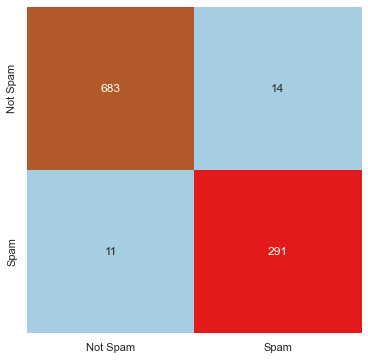

In [47]:
cmat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cmat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam']);

<h4> Pickle the model

In [48]:
import pickle
pickle.dump(svc,open('model.pkl','wb'))